# Behavioral Model

##Mount Drive and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam


Mounted at /content/drive


## Load Dataset

In [2]:

base_path = '/content/drive/MyDrive/ISOT_Web_Interactions(Mouse_Keystroke_SiteAction)_Dataset'

data_types = ['Keystrokes', 'MouseActions', 'SiteActions']
labels = ['genuine', 'attack']

dataset = {dtype: {label: [] for label in labels} for dtype in data_types}

for data_type in data_types:
    for label in labels:
        folder = os.path.join(base_path, data_type, label)
        for file in os.listdir(folder):
            if file.endswith('.txt'):
                path = os.path.join(folder, file)
                try:
                    if data_type == 'SiteActions':
                        df = pd.read_csv(path, sep='\t', header=0, engine='python')
                    else:
                        df = pd.read_csv(path, delimiter=r'\s+', header=None, engine='python')
                    df['source_file'] = file
                    df['label'] = label
                    dataset[data_type][label].append(df)
                except Exception as e:
                    print(f"Error reading {file}: {e}")


## Clean Data

In [3]:
def clean_keystrokes(df):
    if df is None:
        return None
    try:
        if df.shape[1] == 6:
            df.columns = ['User', 'KeyDownTimeStamp', 'KeyReleaseTimeStamp', 'SessionID', 'source_file', 'label']
            df['Type'] = 'Keystroke'
        elif df.shape[1] == 7:
            df.columns = ['User', 'KeyDownTimeStamp', 'KeyReleaseTimeStamp', 'SessionID', 'source_file', 'label', 'Type']
        else:
            print(f"Unexpected keystroke file shape: {df.shape}")
            return None

        df = df[df['User'] != 'User']
        df = df.reset_index(drop=True)
        df['KeyDownTimeStamp'] = df['KeyDownTimeStamp'].astype(int)
        df['KeyReleaseTimeStamp'] = df['KeyReleaseTimeStamp'].astype(int)
        return df
    except Exception as e:
        print(f"Cleaning keystroke error: {e}")
        return None


def clean_mouseactions(df):
    if df is None:
        return None
    try:
        if df.shape[1] == 9:
            df.columns = ['User', 'X', 'Y', 'MouseTimeStamp', 'MouseDownTimeStamp', 'MouseUpTimeStamp', 'SessionID', 'source_file', 'label']
            df['Type'] = 'Mouse'
        elif df.shape[1] == 10:
            df.columns = ['User', 'X', 'Y', 'MouseTimeStamp', 'MouseDownTimeStamp', 'MouseUpTimeStamp', 'SessionID', 'source_file', 'label', 'Type']
        else:
            print(f"Unexpected mouse file shape: {df.shape}")
            return None

        df = df[df['User'] != 'User']
        df = df.reset_index(drop=True)
        df['X'] = df['X'].astype(int)
        df['Y'] = df['Y'].astype(int)
        df['MouseTimeStamp'] = df['MouseTimeStamp'].astype(int)
        df['MouseDownTimeStamp'] = df['MouseDownTimeStamp'].astype(int)
        df['MouseUpTimeStamp'] = df['MouseUpTimeStamp'].astype(int)
        return df
    except Exception as e:
        print(f"Cleaning mouseaction error: {e}")
        return None


def clean_siteactions(df):
    df = df.reset_index(drop=True)
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.dropna(subset=['Time'])
    return df
keystrokes_genuine = pd.concat(dataset['Keystrokes']['genuine'], ignore_index=True)
keystrokes_attack = pd.concat(dataset['Keystrokes']['attack'], ignore_index=True)

mouse_genuine = pd.concat(dataset['MouseActions']['genuine'], ignore_index=True)
mouse_attack = pd.concat(dataset['MouseActions']['attack'], ignore_index=True)

site_genuine = pd.concat(dataset['SiteActions']['genuine'], ignore_index=True)
site_attack = pd.concat(dataset['SiteActions']['attack'], ignore_index=True)

keystrokes_genuine = clean_keystrokes(keystrokes_genuine)
keystrokes_attack = clean_keystrokes(keystrokes_attack)

mouse_genuine = clean_mouseactions(mouse_genuine)
mouse_attack = clean_mouseactions(mouse_attack)

site_genuine = clean_siteactions(site_genuine)
site_attack = clean_siteactions(site_attack)

print("All data cleaned!")


All data cleaned!


<ipython-input-3-dd8194c3ddf9>:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
<ipython-input-3-dd8194c3ddf9>:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], errors='coerce')


## Group Sessions

In [4]:
genuine_sessions = {}
attack_sessions = {}

for sid, group in keystrokes_genuine.groupby('SessionID'):
    genuine_sessions[sid] = {'keystroke': group, 'mouse': None, 'site': None}
for sid, group in mouse_genuine.groupby('SessionID'):
    genuine_sessions.setdefault(sid, {'keystroke': None, 'mouse': None, 'site': None})['mouse'] = group
for sid, group in site_genuine.groupby('SessionID'):
    genuine_sessions.setdefault(sid, {'keystroke': None, 'mouse': None, 'site': None})['site'] = group

for sid, group in keystrokes_attack.groupby('SessionID'):
    attack_sessions[sid] = {'keystroke': group, 'mouse': None, 'site': None}
for sid, group in mouse_attack.groupby('SessionID'):
    attack_sessions.setdefault(sid, {'keystroke': None, 'mouse': None, 'site': None})['mouse'] = group
for sid, group in site_attack.groupby('SessionID'):
    attack_sessions.setdefault(sid, {'keystroke': None, 'mouse': None, 'site': None})['site'] = group

print("Sessions grouped!")


Sessions grouped!


### Prepare Sequential Features

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def prepare_session_sequences_fixed(genuine_sessions, attack_sessions, max_session_length=200):
    X_seq, y_seq = [], []

    def build_sequence(data):
        sequence = []
        if data['keystroke'] is not None and not data['keystroke'].empty:
            ks = data['keystroke'].sort_values('KeyDownTimeStamp')
            ht = ks['KeyReleaseTimeStamp'] - ks['KeyDownTimeStamp']
            idelays = ks['KeyDownTimeStamp'].diff().fillna(0)
            for h, d in zip(ht, idelays):
                sequence.append([float(h), float(d), 0.0, 0.0])
        if data['mouse'] is not None and not data['mouse'].empty:
            ms = data['mouse'].sort_values('MouseTimeStamp')
            dx = np.diff(ms['X'], prepend=ms['X'].iloc[0])
            dy = np.diff(ms['Y'], prepend=ms['Y'].iloc[0])
            t = np.diff(ms['MouseTimeStamp'], prepend=ms['MouseTimeStamp'].iloc[0])
            for dxi, dyi, ti in zip(dx, dy, t):
                speed = np.sqrt(dxi**2 + dyi**2) / (ti + 1)
                sequence.append([float(dxi), float(dyi), float(speed), 0.0])
        if data['site'] is not None and not data['site'].empty:
            site = data['site'].sort_values('Time')
            tdeltas = site['Time'].diff().dt.total_seconds().fillna(0)
            aids = site['Action'].astype('category').cat.codes
            for aid, td in zip(aids, tdeltas):
                sequence.append([float(aid), float(td), 0.0, 0.0])
        return np.array(sequence)

    for sid, data in genuine_sessions.items():
        seq = build_sequence(data)
        X_seq.append(seq)
        y_seq.append(0)
    for sid, data in attack_sessions.items():
        seq = build_sequence(data)
        X_seq.append(seq)
        y_seq.append(1)

    X_seq_padded = pad_sequences(X_seq, maxlen=max_session_length, padding='post', dtype='float32')
    return np.array(X_seq_padded), np.array(y_seq)

X_seq, y_seq = prepare_session_sequences_fixed(genuine_sessions, attack_sessions)
print("Sequential Data Prepared!")


Sequential Data Prepared!


## Scale Features

In [6]:
scaler = MinMaxScaler()
X_seq_scaled = scaler.fit_transform(X_seq.reshape(-1, X_seq.shape[2])).reshape(X_seq.shape)


## DEEP LSTM

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

timesteps = X_seq_scaled.shape[1]
features = X_seq_scaled.shape[2]

inputs = Input(shape=(timesteps, features))

x = LSTM(128, activation='relu', return_sequences=True)(inputs)
x = LSTM(64, activation='relu', return_sequences=True)(x)
x = LSTM(32, activation='relu', return_sequences=False)(x)

encoded = RepeatVector(timesteps)(x)

x = LSTM(32, activation='relu', return_sequences=True)(encoded)
x = LSTM(64, activation='relu', return_sequences=True)(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)

outputs = TimeDistributed(Dense(features))(x)

deep_lstm_autoencoder = Model(inputs, outputs)

deep_lstm_autoencoder.compile(optimizer=Adam(0.0005), loss='mse')

deep_lstm_autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 128)       │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 200, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 200, 4)         │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,404 (1.00 MB)

 Trainable params: 262,404 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
X_train = X_seq_scaled[y_seq == 0]  # Only genuine
X_test = X_seq_scaled[y_seq == 1]  # Only attacks
y_test = y_seq[y_seq == 1]

history = deep_lstm_autoencoder.fit(
    X_train, X_train,
    epochs=150,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)


Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0766 - val_loss: 0.0703
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.0675 - val_loss: 0.0553
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 948ms/step - loss: 0.0493 - val_loss: 0.0210
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 940ms/step - loss: 0.0163 - val_loss: 0.0067
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0063 - val_loss: 0.0061
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 954ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 958ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 966ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0026 - val_loss: 0.0025
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 955ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0024 - val_lo

## Evaluaiton

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
Threshold for anomaly detection: 0.00000638

 Deep LSTM Autoencoder (Attack-Only Test) Performance:
Precision: 1.0000
Recall: 0.8990
F1 Score: 0.9468

Confusion Matrix (Counts):
[[ 0  0]
 [10 89]]

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.8990    0.9468        99

    accuracy                         0.8990        99
   macro avg     0.5000    0.4495    0.4734        99
weighted avg     1.0000    0.8990    0.9468        99



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


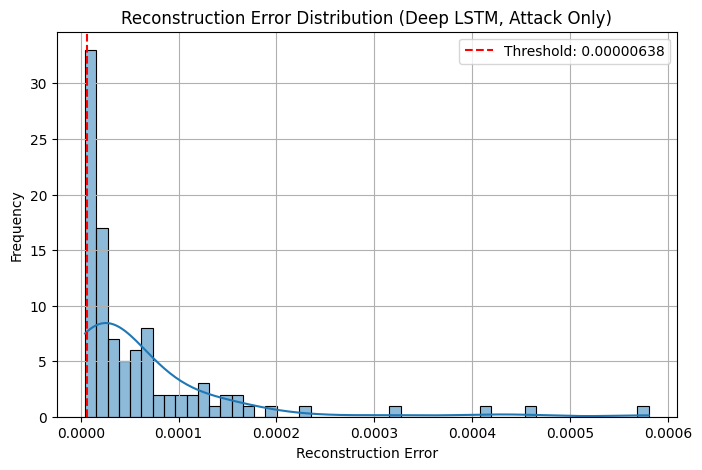

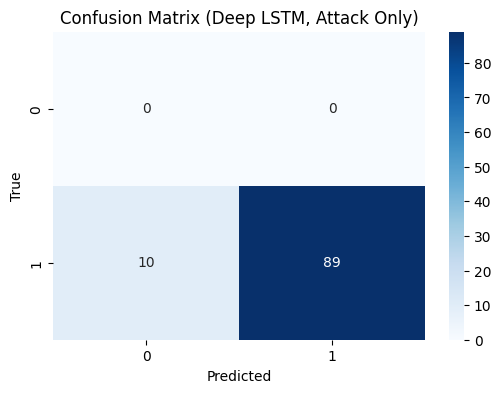

In [9]:
X_test = X_seq_scaled[y_seq == 1]
y_test = y_seq[y_seq == 1]

X_pred = deep_lstm_autoencoder.predict(X_test)

reconstruction_errors = np.mean(np.square(X_test - X_pred), axis=(1,2))

threshold = np.percentile(reconstruction_errors, 10)
print(f"Threshold for anomaly detection: {threshold:.8f}")

y_pred = (reconstruction_errors > threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n Deep LSTM Autoencoder (Attack-Only Test) Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (Counts):")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(8,5))
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.8f}')
plt.title('Reconstruction Error Distribution (Deep LSTM, Attack Only)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Deep LSTM, Attack Only)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Network Model

### Data Load

In [10]:
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt


--2025-04-30 08:47:07--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘KDDTrain+.txt’

KDDTrain+.txt       100%[===================>]  18.22M  39.8MB/s    in 0.5s    

2025-04-30 08:47:10 (39.8 MB/s) - ‘KDDTrain+.txt’ saved [19109424/19109424]

--2025-04-30 08:47:10--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3441513 (3.3M) [text/plain]
Savin

In [11]:
import pandas as pd
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
             "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
             "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
             "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
             "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
             "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]


train_df = pd.read_csv('KDDTrain+.txt', names=col_names)
test_df = pd.read_csv('KDDTest+.txt', names=col_names)

train_df = train_df.drop(columns=['difficulty'])
test_df = test_df.drop(columns=['difficulty'])

print(train_df.shape)
print(test_df.shape)


(125973, 42)
(22544, 42)


### Binary Classification Setup

In [12]:
train_df['label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())


label
0    67343
1    58630
Name: count, dtype: int64
label
1    12833
0     9711
Name: count, dtype: int64


## Label Encoding

In [13]:
from sklearn.preprocessing import LabelEncoder

for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])


## Scale Numerical Features

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(train_df.drop('label', axis=1))
y_train = train_df['label'].values

X_test = scaler.transform(test_df.drop('label', axis=1))
y_test = test_df['label'].values


### 1D CNN Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

#input for CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,233 (153.25 KB)

 Trainable params: 39,233 (153.25 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [16]:
history = model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)


Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8998 - loss: 0.2877 - val_accuracy: 0.9639 - val_loss: 0.1037
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9649 - loss: 0.1046 - val_accuracy: 0.9709 - val_loss: 0.0825
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9701 - loss: 0.0861 - val_accuracy: 0.9715 - val_loss: 0.0713
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9724 - loss: 0.0724 - val_accuracy: 0.9730 - val_loss: 0.0623
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9732 - loss: 0.0672 - val_accuracy: 0.9773 - val_loss: 0.0550
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9749 - loss: 0.0601 - val_accuracy: 0.9804 - val_loss: 0.0530
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9764 - loss: 0.0579 - val_accuracy: 0.9786 - val_loss: 0.0486
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9777 - loss: 0.0543 - val_

## Evaluate

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

y_pred = (model.predict(X_test_cnn) > 0.5).astype("int32")


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n📊 Network 1D CNN Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 Network 1D CNN Performance:
Precision: 0.9676
Recall: 0.6020
F1 Score: 0.7422

Confusion Matrix:
[[9452  259]
 [5107 7726]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6492    0.9733    0.7789      9711
           1     0.9676    0.6020    0.7422     12833

    accuracy                         0.7620     22544
   macro avg     0.8084    0.7877    0.7606     22544
weighted avg     0.8304    0.7620    0.7580     22544



#**Fusion**

##ISOT and NSL-KDD Dataset Test Sample Preparation

In [18]:
# ISOT Web Interaction
X_isot_test = X_seq_scaled[y_seq == 1]
y_isot_test = y_seq[y_seq == 1]
model_isot = deep_lstm_autoencoder

# NSL-KDD
X_nsl_test = X_test_cnn
y_nsl_test = y_test
model_nsl = model


## Meta Neural Network Fusion Model Construction and Evaluation


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

meta_nn = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dropout(0.2),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

meta_nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = meta_nn.fit(
    X_train_fusion, y_train_fusion,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=True
)


y_pred_proba_fusion = meta_nn.predict(X_test_fusion).flatten()
y_pred_fusion = (y_pred_proba_fusion > 0.5).astype(int)


from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

precision = precision_score(y_test_fusion, y_pred_fusion)
recall = recall_score(y_test_fusion, y_pred_fusion)
f1 = f1_score(y_test_fusion, y_pred_fusion)

print(f"\n🚀 Meta Neural Network Fusion Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'X_train_fusion' is not defined

## Attention-Based and Meta Neural Network Prediction Stacking for Fusion


In [ ]:

y_pred_proba_attention = attention_model.predict(X_test_fusion).flatten()
y_pred_proba_meta_nn = meta_nn.predict(X_test_fusion).flatten()

stacked_X = np.column_stack([y_pred_proba_attention, y_pred_proba_meta_nn])

from sklearn.linear_model import LogisticRegression


super_meta_model = LogisticRegression()
super_meta_model.fit(stacked_X, y_test_fusion)


y_pred_stacked = super_meta_model.predict(stacked_X)

precision = precision_score(y_test_fusion, y_pred_stacked)
recall = recall_score(y_test_fusion, y_pred_stacked)
f1 = f1_score(y_test_fusion, y_pred_stacked)

print(f"\n🚀 STACKED FUSION Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


##Super Meta Neural Network Construction for Stacked Fusion Enhancement


In [ ]:
super_meta_nn = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dropout(0.2),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

super_meta_nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_super_meta = super_meta_nn.fit(
    stacked_X, y_test_fusion,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    shuffle=True
)

y_pred_proba_super_meta = super_meta_nn.predict(stacked_X).flatten()
y_pred_super_meta = (y_pred_proba_super_meta > 0.5).astype(int)

precision = precision_score(y_test_fusion, y_pred_super_meta)
recall = recall_score(y_test_fusion, y_pred_super_meta)
f1 = f1_score(y_test_fusion, y_pred_super_meta)

print(f"\n🚀 Super Meta Neural Net Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


## *Weighted* Voting Mechanism Based on ISOT and NSL-KDD Scores


In [ ]:

isot_test_scores = X_test_fusion[:, 0]
nsl_test_scores = X_test_fusion[:, 1]

y_pred_isot_test = (isot_test_scores > 0.5).astype(int)
y_pred_nsl_test = (nsl_test_scores > 0.5).astype(int)

weight_isot = 0.4
weight_nsl = 0.6

weighted_vote_score = (weight_isot * y_pred_isot_test) + (weight_nsl * y_pred_nsl_test)
weighted_vote_proba = weighted_vote_score / (weight_isot + weight_nsl)

print(f"Weighted voting shape: {weighted_vote_proba.shape}")


##Feature Engineering for Ultimate Fusion: Combining Fused and Raw Scores


In [ ]:
fusion_X_new = np.column_stack([
    y_pred_proba_attention,
    y_pred_proba_meta_nn,
    weighted_vote_proba,
    isot_test_scores,
    nsl_test_scores
])

print(f"Fusion X shape: {fusion_X_new.shape}")

fusion_y_new = y_test_fusion


##Ultimate Fusion Model Training Using LightGBM with Stratified Cross-Validation


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(fusion_X_new, fusion_y_new)):
    X_train, X_val = fusion_X_new[train_idx], fusion_X_new[val_idx]
    y_train, y_val = fusion_y_new[train_idx], fusion_y_new[val_idx]

    model = lgb.LGBMClassifier(
        learning_rate=0.01,
        max_depth=4,
        n_estimators=500,
        num_leaves=16,
        boosting_type='gbdt',
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    y_pred_val = model.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)

    print(f"Fold {fold+1} F1 Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_model = model

print(f"\n🚀 Best F1 across folds: {best_f1:.4f}")


##Feature Importance Analysis of Ultimate Fusion Model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importance = best_model.feature_importances_
feature_names = ['Attention Fusion', 'Meta Neural Net', 'Weighted Voting', 'Raw ISOT', 'Raw NSL CNN']

indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[indices], align='center', color='skyblue')
plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
plt.title('Feature Importance - Ultimate Fusion (LightGBM)', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance (Gain)', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
